In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
np.random.seed(0)
torch.manual_seed(0)

In [5]:
#create a simple 2D classification dataset that is linearly separable
X = np.random.randn(1000, 2)
y = (X[:, 0] + X[:, 1] > 0).astype(np.float32)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val   = torch.tensor(X_val, dtype=torch.float32)
y_val   = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

In [7]:
#create data loaders
train_ds = TensorDataset(X_train, y_train)
val_ds   = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

In [9]:
#define model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

model = SimpleNN()

In [11]:
#specify loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [13]:
#training and validation functions
def train_one_epoch(model, loader, criterion, optimizer):
    model.train() #enables training behavior
    running_loss = 0.0

    for X_batch, y_batch in loader:
        logits = model(X_batch)
        loss = criterion(logits, y_batch)

        optimizer.zero_grad() #initializes gradient by clearing old
        loss.backward() #solving for gradients
        optimizer.step() #updating weights

        running_loss += loss.item() * X_batch.size(0) 

    return running_loss / len(loader.dataset)


def eval_one_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            running_loss += loss.item() * X_batch.size(0)

    return running_loss / len(loader.dataset)

In [15]:
#full training loop here
epochs = 30
train_losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss = eval_one_epoch(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 01 | Train Loss: 0.3394 | Val Loss: 0.0654
Epoch 02 | Train Loss: 0.0461 | Val Loss: 0.0280
Epoch 03 | Train Loss: 0.0263 | Val Loss: 0.0243
Epoch 04 | Train Loss: 0.0244 | Val Loss: 0.0180
Epoch 05 | Train Loss: 0.0181 | Val Loss: 0.0319
Epoch 06 | Train Loss: 0.0207 | Val Loss: 0.0169
Epoch 07 | Train Loss: 0.0197 | Val Loss: 0.0165
Epoch 08 | Train Loss: 0.0194 | Val Loss: 0.0544
Epoch 09 | Train Loss: 0.0329 | Val Loss: 0.0409
Epoch 10 | Train Loss: 0.0190 | Val Loss: 0.0217
Epoch 11 | Train Loss: 0.0147 | Val Loss: 0.0228
Epoch 12 | Train Loss: 0.0183 | Val Loss: 0.0137
Epoch 13 | Train Loss: 0.0142 | Val Loss: 0.0189
Epoch 14 | Train Loss: 0.0143 | Val Loss: 0.0229
Epoch 15 | Train Loss: 0.0176 | Val Loss: 0.0201
Epoch 16 | Train Loss: 0.0117 | Val Loss: 0.0151
Epoch 17 | Train Loss: 0.0198 | Val Loss: 0.0127
Epoch 18 | Train Loss: 0.0289 | Val Loss: 0.0597
Epoch 19 | Train Loss: 0.0170 | Val Loss: 0.0090
Epoch 20 | Train Loss: 0.0198 | Val Loss: 0.0470
Epoch 21 | Train Los

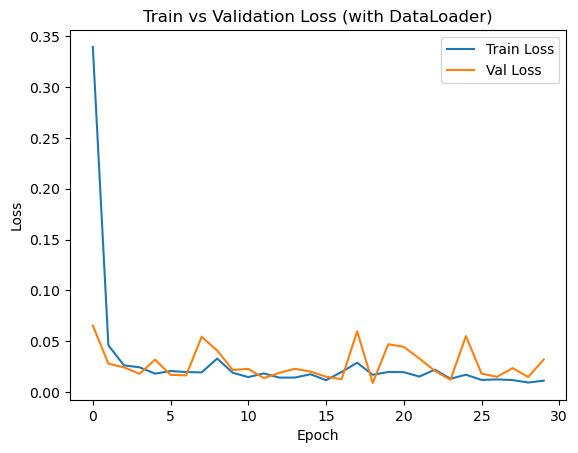

In [17]:
#plot loss curves
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss (with DataLoader)")
plt.legend()
plt.show()

In [19]:
#accuracy (Checking validation)
model.eval()
with torch.no_grad():
    logits = model(X_val)
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    acc = (preds.eq(y_val)).float().mean().item()

print("Validation Accuracy:", acc)

Validation Accuracy: 0.9919999837875366


## Key Takeaways

- DataLoaders provide batching and shuffling — essential for scaling to real datasets.
- A clean pipeline separates training vs evaluation behavior (`model.train()` vs `model.eval()`).
- Tracking train vs validation loss helps detect underfitting/overfitting early.
- This structure is reusable for CNNs and larger deep learning workflows.